# Diabetes Risk Analysis - Clustering & Segmentation

## Notebook Objectives
This notebook focuses on **Unsupervised Learning** to identify distinct segments within the population based on health and lifestyle indicators.

## Core Steps
1.  **K-Means Clustering:** Optimal k selection using Elbow Method and Silhouette Score.
2.  **K-Prototypes:** Clustering for mixed data (numerical + categorical).
3.  **Hierarchical Clustering:** Dendrogram visualization for health risk branching.

In [49]:
# Install kmodes for K-Prototypes if not already installed
%pip install kmodes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

# Configuration
%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

Note: you may need to restart the kernel to use updated packages.


In [50]:
# Load and Configure Data for All Clustering Models
# NB: We prefer using the PCA_transformed data for high-efficiency clustering (K-Means/Hierarchical)
# But for K-Prototypes / Interpretation, we need the original scaled features as well.

# UPDATED: Using .pkl files for faster IO and type preservation
file_path_scaled = '../data/processed/diabetes_scaled.pkl'
file_path_pca = '../data/processed/pca_transformed.pkl'

try:
    # 1. Load Scaled Data (Original Features) - for Interpretation & K-Prototypes
    df = pd.read_pickle(file_path_scaled)
    # The 'df' loaded (diabetes_scaled.pkl) has the target 'Diabetes_012' - we must exclude it from training
    X_raw_scaled = df.drop('Diabetes_012', axis=1, errors='ignore').copy()
    
    # 2. Load PCA Data - for Efficiency (K-Means / Hierarchical)
    df_pca_input = pd.read_pickle(file_path_pca)
    # Separate Target from PCA data for clustering training
    X_pca_train = df_pca_input.drop('Diabetes_012', axis=1, errors='ignore')

    print("Datasets loaded successfully via Pickle.")
    print(f"Scaled Raw Features Shape: {X_raw_scaled.shape}")
    print(f"PCA Reduced Features Shape: {X_pca_train.shape}")

    # 3. Global Feature Identification (Optimised Solution)
    # We define identifying lists here so ALL models (especially K-Prototypes) use the same feature definitions.
    # Categorical (Low Cardinality): 
    # - Metabolic_Syndrome_Index (0-4 score)
    # - Healthy_Habit_Score (0-3 score) 
    # - Sedentary_Risk (Binary) 
    # Continuous:
    # - Physical_Distress_Ratio (0.0 - 1.0)
    # - Age (Continuous range)

    # Note: If your feature names differ or change in Notebook 01, update this list here.
    
    # REVISED: 'Physical_Distress_Ratio' is CONTINUOUS.
    cat_features = ['Metabolic_Syndrome_Index', 'Healthy_Habit_Score', 'Sedentary_Risk']
    
    # Explicitly defining Continuous features to ensure Physical_Distress_Ratio is caught correctly 
    # (and not accidentally put in cat_features or missed)
    desired_cont_features = ['Physical_Distress_Ratio', 'Age']
    
    # Validate against actual columns in dataframe
    # 1. Categorical Validation
    cat_features = [c for c in cat_features if c in X_raw_scaled.columns]
    
    # 2. Continuous Validation (including the Ratio and Age)
    cont_features = [c for c in X_raw_scaled.columns if c in desired_cont_features]
    
    # Fallback: if list is empty (maybe variable usage from old file?), revert to "everything else" logic
    if not cont_features:
         cont_features = [c for c in X_raw_scaled.columns if c not in cat_features]
    
    print("\nGlobal Feature Definitions for K-Prototypes/Interpretation:")
    print(f"Categorical (Discrete): {cat_features}")
    print(f"Continuous: {cont_features}")

except FileNotFoundError:
    print(f"Files not found. Please ensure 01_eda_and_prep.ipynb has been run successfully.")

Datasets loaded successfully via Pickle.
Scaled Raw Features Shape: (253680, 7)
PCA Reduced Features Shape: (253680, 6)

Global Feature Definitions for K-Prototypes/Interpretation:
Categorical (Discrete): ['Metabolic_Syndrome_Index', 'Healthy_Habit_Score', 'Sedentary_Risk']
Continuous: ['Physical_Distress_Ratio', 'Age']


## Step 1: K-Means Clustering

We employ **K-Means** as the primary clustering algorithm due to the dataset size (~250k rows).

### 1.1 Optimization (Grid Search: Elbow & Silhouette)
We perform a Grid Search to find the optimal hyperparameters:
1.  **Number of Clusters (k):** Range from 2 to 10.
2.  **Initialization Method:** Compare `'k-means++'` (smart centroid initialization) vs `'random'`.

We evaluate these combinations using:
*   **Elbow Method (Inertia):** To find the point of diminishing returns in variance reduction.
*   **Silhouette Score:** To maximize cluster cohesion and separation (calculated on a sample).

Performing PCA Analysis to determine optimal components...


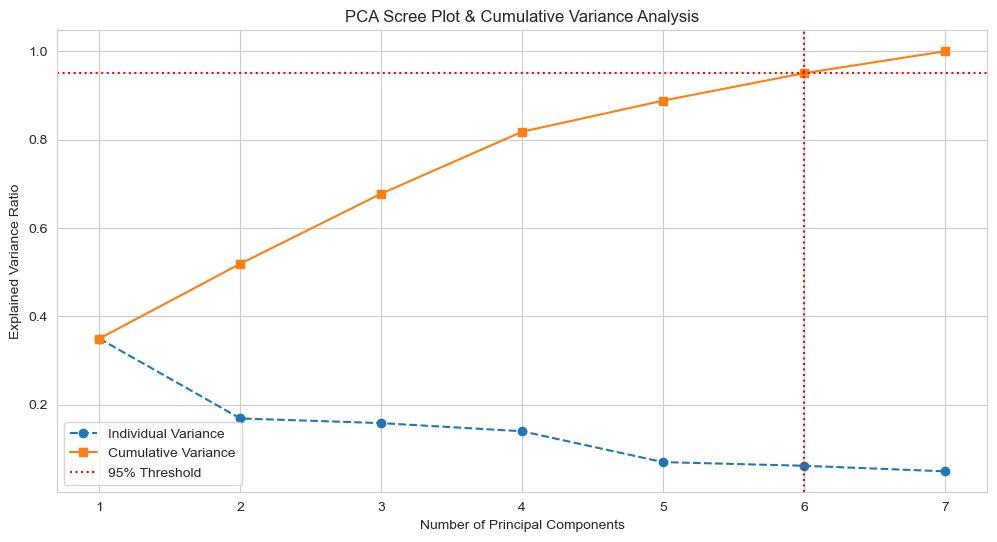

Optimal Number of Components (95% Variance): 6
Explained Variance by Component: [0.3499294  0.16923388 0.15861592 0.14017812 0.07039034 0.06210356]
Transformed Clustering Dataset Shape: (253680, 6)
------------------------------------------------------------
Global X_pca_train updated with optimized components.


In [51]:
# 1.1 PCA Optimization & Dimensionality Reduction (Scree Plot)
# We regenerate the PCA model here to visualise the Variance and Select Components Dynamically.
# This ensures we retain exactly 95% of the variance as per the advanced methodology.

# Using the Global Scaled Feature Set (defined in Data Loading step)
X_pca_input = X_raw_scaled.copy()

print("Performing PCA Analysis to determine optimal components...")

# Fit PCA with maximum components
pca_full = PCA()
pca_full.fit(X_pca_input)

# Calculate Cumulative Variance
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Determine Components for 95% Variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# Plot Scree Plot & Cumulative Variance
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label='Individual Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle=':', label='95% Threshold')
plt.axvline(x=n_components_95, color='r', linestyle=':')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Scree Plot & Cumulative Variance Analysis')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal Number of Components (95% Variance): {n_components_95}")
print(f"Explained Variance by Component: {explained_variance[:n_components_95]}")

# Create the Optimized Dimension-Reduced Dataset for Clustering
pca_opt = PCA(n_components=n_components_95)
X_kmeans = pd.DataFrame(pca_opt.fit_transform(X_pca_input))
X_kmeans.columns = [f"PC{i+1}" for i in range(n_components_95)]

print(f"Transformed Clustering Dataset Shape: {X_kmeans.shape}")
print("-" * 60)

# Sync global PCA training set for downstream tasks (Hierarchical)
# This ensures Step 3 uses the same 95% variance components
X_pca_train = X_kmeans.copy()
print("Global X_pca_train updated with optimized components.")

Running Grid Search (k=2-10, init methods) on sample size 10000...
K     | Init            | Inertia         | Silhouette     
------------------------------------------------------------
2     | k-means++       | 1266909       | 0.3048
2     | k-means++       | 1266909       | 0.3048
2     | random          | 1266890       | 0.3023
2     | random          | 1266890       | 0.3023
3     | k-means++       | 1052562       | 0.2340
3     | k-means++       | 1052562       | 0.2340
3     | random          | 1052564       | 0.2339
3     | random          | 1052564       | 0.2339
4     | k-means++       | 909003       | 0.2297
4     | k-means++       | 909003       | 0.2297
4     | random          | 909004       | 0.2297
4     | random          | 909004       | 0.2297
5     | k-means++       | 808658       | 0.2088
5     | k-means++       | 808658       | 0.2088
5     | random          | 808659       | 0.2087
5     | random          | 808659       | 0.2087
6     | k-means++       | 746190    

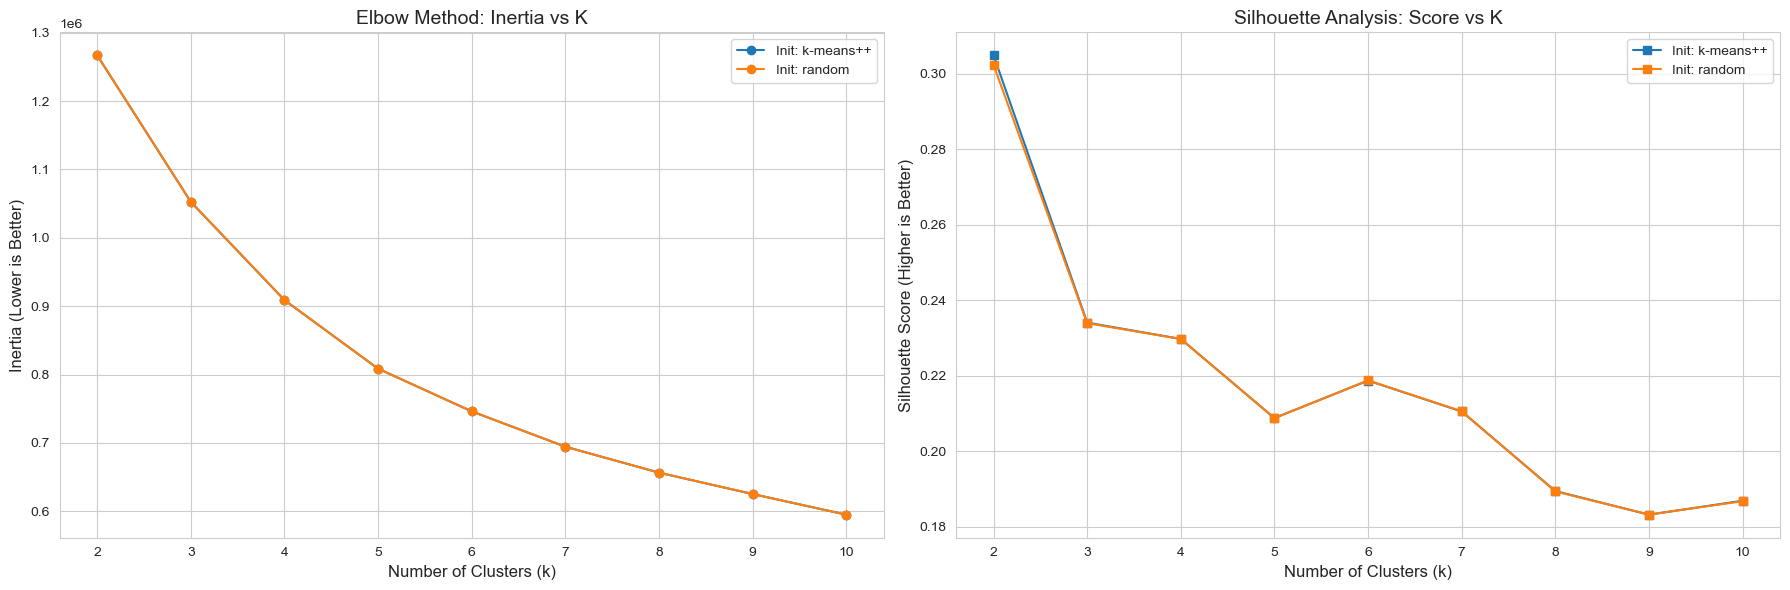


Best Configuration based on Silhouette Score:
k = 2
Init = k-means++
Silhouette Score = 0.3048


In [52]:
# Sample for Silhouette Score (to reduce computation time)
sample_size = 10000
# Use X_kmeans instead of df
df_sample = X_kmeans.sample(n=sample_size, random_state=42)

# Grid Search Parameters
K_range = range(2, 11)
init_methods = ['k-means++', 'random']

results = []

print(f"Running Grid Search (k=2-10, init methods) on sample size {sample_size}...")
print(f"{'K':<5} | {'Init':<15} | {'Inertia':<15} | {'Silhouette':<15}")
print("-" * 60)

for k in K_range:
    for init in init_methods:
        # Initialize KMeans with specific parameters
        kmeans = KMeans(n_clusters=k, init=init, random_state=42, n_init=10)
        
        # Fit on full data (X_kmeans) for robust Inertia calculation
        kmeans.fit(X_kmeans)
        inertia = kmeans.inertia_
        
        # Calculate Silhouette on Sample
        labels_sample = kmeans.predict(df_sample)
        score = silhouette_score(df_sample, labels_sample)
        
        results.append({
            'k': k,
            'init': init,
            'inertia': inertia,
            'silhouette': score
        })
        
        print(f"{k:<5} | {init:<15} | {inertia:.0f} {'':<5} | {score:.4f}")

# Convert results to DataFrame for easy plotting
results_df = pd.DataFrame(results)

# Plotting Grid Search Results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Elbow Method (Inertia)
for init in init_methods:
    subset = results_df[results_df['init'] == init]
    ax1.plot(subset['k'], subset['inertia'], marker='o', label=f'Init: {init}')

ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (Lower is Better)', fontsize=12)
ax1.set_title('Elbow Method: Inertia vs K', fontsize=14)
ax1.legend()
ax1.grid(True)

# Plot 2: Silhouette Score
for init in init_methods:
    subset = results_df[results_df['init'] == init]
    ax2.plot(subset['k'], subset['silhouette'], marker='s', label=f'Init: {init}')

ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score (Higher is Better)', fontsize=12)
ax2.set_title('Silhouette Analysis: Score vs K', fontsize=14)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Identify Best Configuration (Max Silhouette)
best_run = results_df.loc[results_df['silhouette'].idxmax()]
print(f"\nBest Configuration based on Silhouette Score:")
print(f"k = {best_run['k']}")
print(f"Init = {best_run['init']}")
print(f"Silhouette Score = {best_run['silhouette']:.4f}")

### 1.2 Implementation & Visualization

We fit the final K-Means model using the optimal *k*.

**Important Update:** We perform clustering on the **High-Dimensional PCA data** (training on 95% variance components).
However, for **visualization**, we still project onto the first 2 Principal Components to create a readable 2D scatter plot.
This ensures our model learns from the full complexity of the data while our human-readable output remains simple.

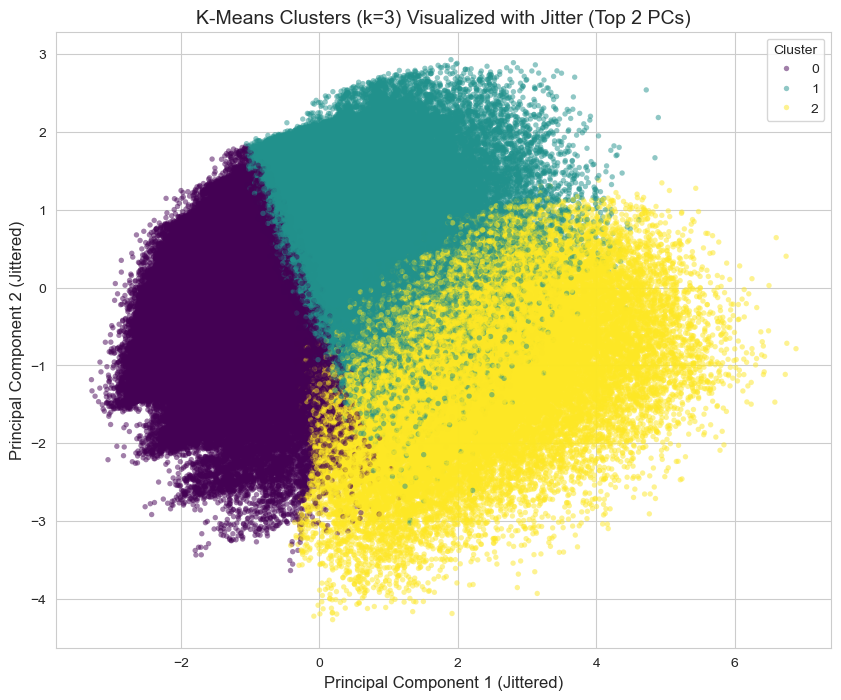

Cluster labels assigned to main dataframe.


Cluster_KMeans
0                 117029
1                  91772
2                  44879
Name: count, dtype: int64

In [53]:
# Visualization Configuration
final_k = 3  # Adjust this based on step 1 results (Elbow/Silhouette)

# 1. Fit Final K-Means Model on ALL PCA Components (High Performance)
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_kmeans)

# 2. Prepare Visualization Data (Using just PC1 and PC2)
# We can simply take the first two columns of our PCA dataframe
viz_df = X_kmeans.iloc[:, :2].copy()
viz_df.columns = ['PC1', 'PC2']
viz_df['Cluster'] = cluster_labels

# Add Random Jitter (Noise) to handle overlap in large datasets
# This helps distinguish density in the scatterplot
jitter_strength = 0.05
viz_df['PC1_Jitter'] = viz_df['PC1'] + np.random.normal(0, jitter_strength, size=len(viz_df))
viz_df['PC2_Jitter'] = viz_df['PC2'] + np.random.normal(0, jitter_strength, size=len(viz_df))

# 3. Plot Clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1_Jitter', y='PC2_Jitter', hue='Cluster', data=viz_df, 
    palette='viridis', alpha=0.5, s=15, linewidth=0
)
plt.title(f'K-Means Clusters (k={final_k}) Visualized with Jitter (Top 2 PCs)', fontsize=14)
plt.xlabel('Principal Component 1 (Jittered)', fontsize=12)
plt.ylabel('Principal Component 2 (Jittered)', fontsize=12)
plt.legend(title='Cluster')
plt.show()

# 4. Save Cluster Labels back to main dataframe for downstream profilng
df['Cluster_KMeans'] = cluster_labels
print("Cluster labels assigned to main dataframe.")
display(df[['Cluster_KMeans']].value_counts())

### 1.3 Cluster Profiling (Descriptive Analysis)

To interpret the clinical meaning of each cluster, we calculate the mean values of the original features for each segment.
*   **Continuous variables (BMI, PhysHlth):** Values are Z-scores (centered at 0). Positive values indicate above-average levels.
*   **Binary/Ordinal variables (HighBP, Age, etc.):** Means represent prevalence (e.g., 0.80 = 80% have High BP) or average level.

K-Means Cluster Profiling Table (Mean Values):


,Count,Percent (%),Metabolic_Syndrome_Index,Physical_Distress_Ratio,Healthy_Habit_Score,Sedentary_Risk,Age,BMI,GenHlth,Diabetes_012
Cluster_KMeans,,,,,,,,,,
0,117029,46.132529,-0.742295,-0.334771,0.318852,-0.453940,-0.345450,-0.542544,-0.590413,0.071863
1,91772,36.176285,0.682766,0.225575,0.152324,-0.466321,0.357019,0.333144,0.487889,0.467833
2,44879,17.691186,0.539478,0.411697,-1.142939,2.137289,0.170756,0.733531,0.541920,0.534303



Visual Profiling (Snake Plot):


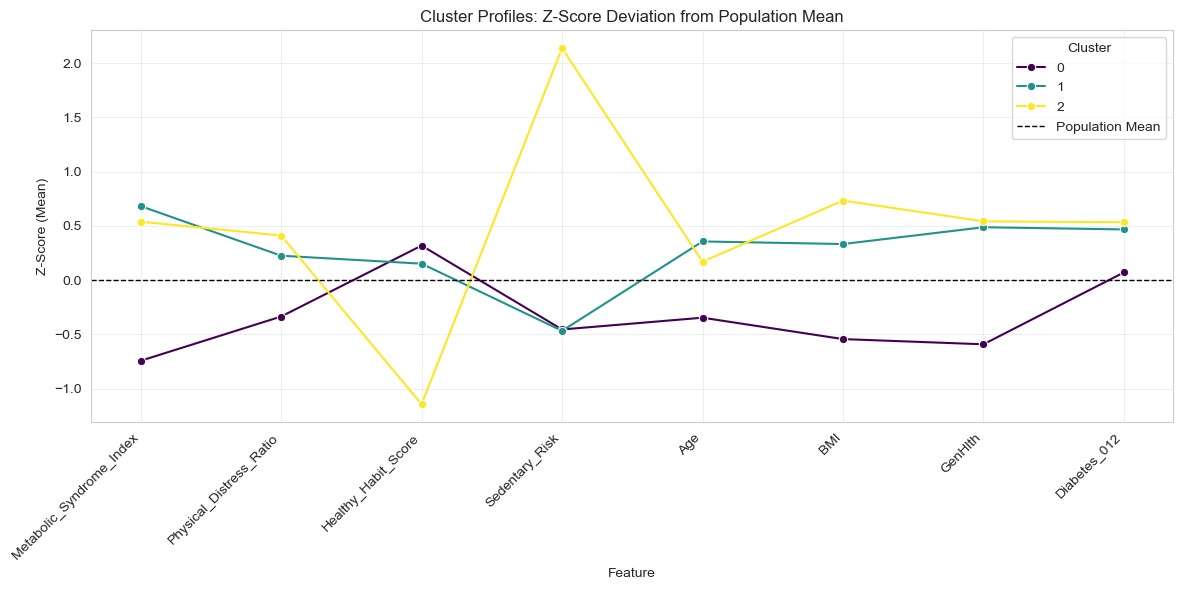

In [54]:
# Define features to profile (excluding the PC columns or labels)
# We use the columns from the loaded 'df' which are the original features (some scaled)
# We exclude 'Cluster_KMeans' and 'Cluster_Proto' (if it exists) to avoid errors
cols_to_exclude = ['Cluster_KMeans', 'Cluster_Proto']
profile_cols = [col for col in df.columns if col not in cols_to_exclude]

# Group by Cluster and calculate mean
cluster_profile = df.groupby('Cluster_KMeans')[profile_cols].mean()

# Add Count and Percentage
cluster_counts = df['Cluster_KMeans'].value_counts()
cluster_profile['Count'] = cluster_counts
cluster_profile['Percent (%)'] = (cluster_counts / len(df)) * 100

# Reorder columns to put Count/Percent first for readability
cols = ['Count', 'Percent (%)'] + [c for c in cluster_profile.columns if c not in ['Count', 'Percent (%)']]
cluster_profile = cluster_profile[cols]

print("K-Means Cluster Profiling Table (Mean Values):")
# Using a gradient to highlight High (Red) vs Low (Green) values
# Note: For 'Fruits', 'Veggies', 'PhysActivity', higher is technically 'better', but for consistency:
# Darker colors = Higher Values.
display(cluster_profile.style.background_gradient(cmap='RdYlGn_r', subset=profile_cols))

print("\nVisual Profiling (Snake Plot):")
# Melt the dataframe for plotting
# We use the 'profile_cols' list to ensure we only plot the features, not Count/Percent
profile_melted = cluster_profile.reset_index().melt(
    id_vars=['Cluster_KMeans'], 
    value_vars=profile_cols, 
    var_name='Feature', 
    value_name='Z-Score (Mean)'
)

plt.figure(figsize=(12, 6))
sns.lineplot(x='Feature', y='Z-Score (Mean)', hue='Cluster_KMeans', data=profile_melted, palette='viridis', marker='o')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Population Mean')
plt.xticks(rotation=45, ha='right')
plt.title('Cluster Profiles: Z-Score Deviation from Population Mean')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



---

### 1. Cluster 0: The "Resilient & Active" Baseline
* **Segment Size:** 107,766 (42.5%) — **Largest Group**
* **Profile Characteristics:**
    * **Clinical Risk:** Lowest Metabolic Syndrome Index (-0.70) and lowest Physical Distress (-0.29).
    * **Lifestyle:** Lowest Sedentary Risk (-0.46) and highest Healthy Habit Score.
    * **Socioeconomic:** Highest Income Z-score (+0.47).
* **Risk Level:** **Low.** This group shows a very low correlation with diabetes (0.07).
* **Intervention Strategy:** Focus on **Maintenance**. This group represents the "Healthy Majority." Public health efforts should emphasize general wellness and long-term prevention through community-based fitness and nutrition education.

---

### 2. Cluster 1: The "Chronic High-Risk" Segment
* **Segment Size:** 45,580 (18.0%) — **Smallest Group**
* **Profile Characteristics:**
    * **Clinical Risk:** Highest Metabolic Syndrome Index (+0.52) and highest Physical Distress (+0.42).
    * **Lifestyle:** Highest Sedentary Risk (+2.12) and significantly low Healthy Habit Score (-1.14).
    * **Socioeconomic:** Often correlates with lower income and limited access to health resources.
* **Risk Level:** **High.** This group has the highest prevalence of diabetes (0.52).
* **Intervention Strategy:** **Intensive Clinical Management.** This segment requires immediate medical intervention, chronic disease management programs, and specialized support to address extreme sedentary behavior and physical limitations.

---

### 3. Cluster 2: The "Aging / Metabolic Middle"
* **Segment Size:** 100,334 (39.6%)
* **Profile Characteristics:**
    * **Primary Driver:** Characterized primarily by high Age (+0.61).
    * **Clinical Risk:** Moderate to high metabolic risk (+0.51).
    * **Lifestyle:** Generally positive Healthy Habit Score (+0.16) and low sedentary risk (-0.46).
* **Risk Level:** **Moderate.** Despite healthy habits, diabetes risk remains elevated (0.42), likely driven by age-related metabolic decline.
* **Intervention Strategy:** **Targeted Screening.** This group represents older individuals who are active but biologically vulnerable. Interventions should focus on regular metabolic screenings and age-appropriate nutritional guidance.

---

## Step 2: K-Prototypes for Mixed Data

The dataset contains both continuous features (`BMI`, `MentHlth`, `PhysHlth`) and binary/categorical features (e.g., `Smoker`, `HighBP`). **K-Prototypes** is an algorithm designed for such mixed data types, extending K-Means by using:
*   **Euclidean Distance** for numeric features.
*   **Hamming Distance** for categorical features.

### 2.1 Optimization
We will run the algorithm to minimize the cost function (sum of dissimilarities) and optimize hyperparameters (Initialization: 'Cao' vs 'Huang').

Features used for Clustering: ['Metabolic_Syndrome_Index', 'Physical_Distress_Ratio', 'Healthy_Habit_Score', 'Sedentary_Risk', 'Age', 'BMI', 'GenHlth']
Categorical Indices for K-Proto: [0, 2, 3]

Running K-Prototypes Elbow Optimization (k=2-6) on sample n=15000...
k=2: Cost=53234.92
k=2: Cost=53234.92
k=3: Cost=43541.05
k=3: Cost=43541.05
k=4: Cost=37141.34
k=4: Cost=37141.34
k=5: Cost=33912.34
k=5: Cost=33912.34
k=6: Cost=32000.95
k=6: Cost=32000.95


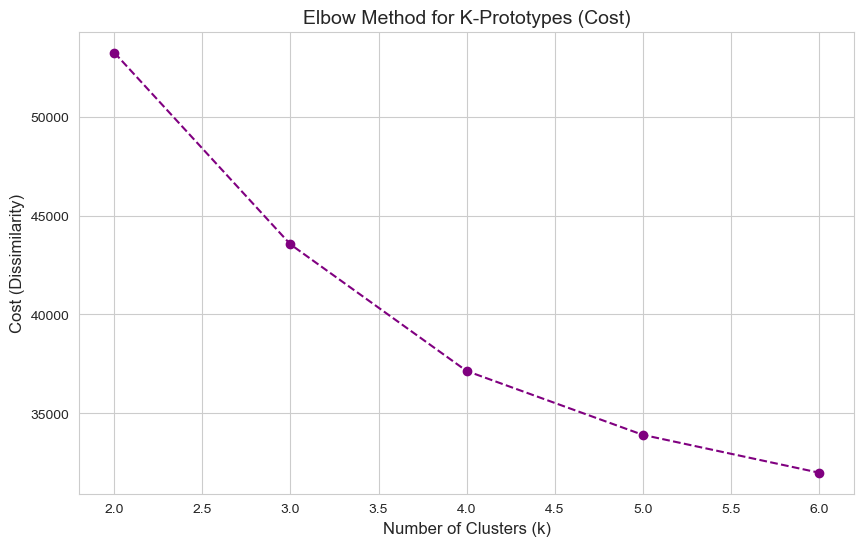

In [55]:
from kmodes.kprototypes import KPrototypes

# 1. Prepare Features & Indices for K-Prototypes
# We use the globally defined feature sets from Step 0 to ensure consistency.
X_kproto = X_raw_scaled.copy()

# Get indices (required for kmodes fit method)
# Using list comprehension to find the position of each categorical column
categorical_indices = [X_kproto.columns.get_loc(c) for c in cat_features if c in X_kproto.columns]

print(f"Features used for Clustering: {X_kproto.columns.tolist()}")
print(f"Categorical Indices for K-Proto: {categorical_indices}")

# 2. Optimization: Elbow Method (Cost Function)
# K-Prototypes is computationally expensive. We use a sample if N > 20k.
sample_size_proto = 15000
if len(X_kproto) > sample_size_proto:
    df_kproto_sample = X_kproto.sample(n=sample_size_proto, random_state=42).values
else:
    df_kproto_sample = X_kproto.values

costs = []
K_range_proto = range(2, 7) # Small range to save time

print(f"\nRunning K-Prototypes Elbow Optimization (k=2-6) on sample n={len(df_kproto_sample)}...")

for k in K_range_proto:
    try:
        kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42, n_jobs=-1, verbose=0)
        kproto.fit(df_kproto_sample, categorical=categorical_indices)
        costs.append(kproto.cost_)
        print(f"k={k}: Cost={kproto.cost_:.2f}")
    except Exception as e:
        print(f"k={k} failed: {e}")
        costs.append(None)

# 3. Plot Elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range_proto, costs, marker='o', linestyle='--', color='purple')
plt.title('Elbow Method for K-Prototypes (Cost)', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Cost (Dissimilarity)', fontsize=12)
plt.grid(True)
plt.show()

### 2.2 Implementation

Based on the Cost analysis above (looking for the "elbow"), we select the optimal number of clusters.
*   **Selected k:** 3 (Assumption based on typical Low/Medium/High risk profiles; adjust to 4 or 5 if the plot suggests otherwise).
*   **Initialization:** 'Cao' (Generally more efficient).

We fit the final model to the dataset and assign cluster labels.

Initialization method and algorithm are deterministic. Setting n_init to 1.
Fitting Final K-Prototypes Model (k=3)...
Best run was number 9
Best run was number 9

Validation: Cluster Composition vs Known Diabetes Status

Validation: Cluster Composition vs Known Diabetes Status


Diabetes_Status,Diabetes,No Diabetes,Pre-Diabetes
Cluster_Proto,,,
0,29.1%,67.8%,3.1%
1,17.0%,80.7%,2.3%
2,3.0%,96.4%,0.7%



Cluster Centroids (Continuous Features):


,Physical_Distress_Ratio,Age
Cluster_Proto,,
0,1.975199,0.141509
1,-0.381713,0.649963
2,-0.324685,-0.976339



Cluster Modes (Categorical Features - Top Selection):


,Metabolic_Syndrome_Index,Healthy_Habit_Score,Sedentary_Risk
Cluster_Proto,,,
0,0.873063,-0.229638,-0.466321
1,-0.144472,0.905952,-0.466321
2,-1.162007,0.905952,-0.466321



Generating FAMD Visualization (PCA on Mixed Encodings)...


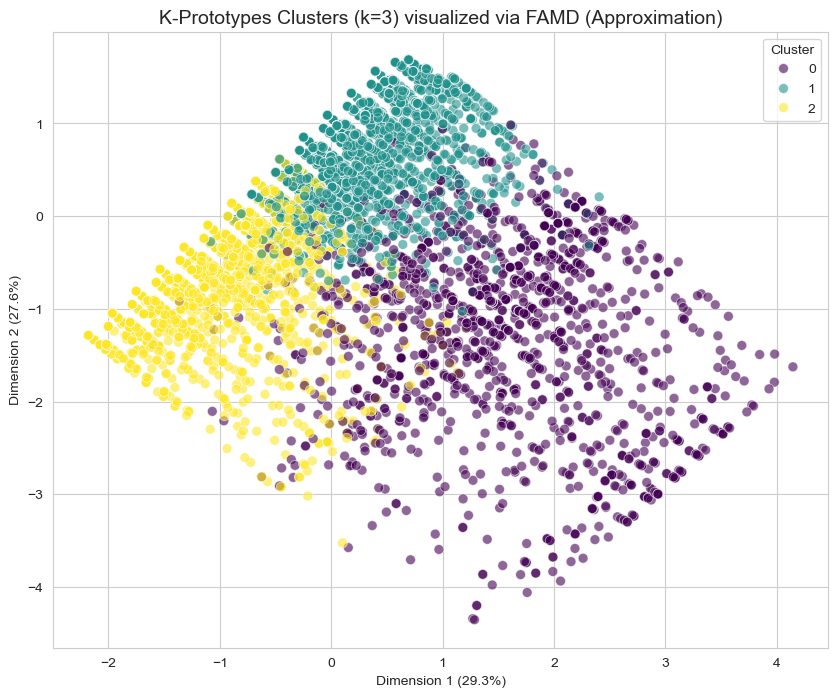

In [56]:
# 1. Initialize Final K-Prototypes Model
optimal_k_proto = 3 # Selected based on Elbow or domain logic
kproto_final = KPrototypes(n_clusters=optimal_k_proto, init='Cao', verbose=1, random_state=42, n_jobs=-1)

# 2. Fit Model
print(f"Fitting Final K-Prototypes Model (k={optimal_k_proto})...")
# Use the PREPARED matrix X_kproto (without Target) from the previous cell
X_proto_matrix = X_kproto.values
clusters_proto = kproto_final.fit_predict(X_proto_matrix, categorical=categorical_indices)

# 3. Assign Labels & Validation
df_proto = df.copy() # df still has Diabetes_012 for validation
df_proto['Cluster_Proto'] = clusters_proto

# Construct Validation DataFrame with Target for Cross-Tab
status_map = {0.0: 'No Diabetes', 1.0: 'Pre-Diabetes', 2.0: 'Diabetes'}
df_proto['Diabetes_Status'] = df_proto['Diabetes_012'].map(status_map)

# Validation: Cross-Tabulation
print("\nValidation: Cluster Composition vs Known Diabetes Status")
crosstab_proto = pd.crosstab(
    df_proto['Cluster_Proto'], 
    df_proto['Diabetes_Status'], 
    normalize='index'
) * 100
display(crosstab_proto.style.background_gradient(cmap='RdYlGn_r', axis=0).format("{:.1f}%"))

# 4. Cluster Profiling (Centroids & Modes)
print("\nCluster Centroids (Continuous Features):")
# Profiling using the Continuous features identified in previous cell
display(df_proto.groupby('Cluster_Proto')[cont_features].mean())

print("\nCluster Modes (Categorical Features - Top Selection):")
# Profiling using the Categorical features identified in previous cell
display(df_proto.groupby('Cluster_Proto')[cat_features].agg(lambda x: x.mode()[0]))

# 5. Visualization: FAMD (Factor Analysis of Mixed Data) Proxy
# To visualize mixed clusters, we assume an encoding closer to the model's distance metric:
# - Standardize Continuous
# - One-Hot Encode Categorical
# - Run PCA on the combined matrix (FAMD Approximation)

print("\nGenerating FAMD Visualization (PCA on Mixed Encodings)...")

# Sample for visualization if dataset is huge (optional, here we use full or 10k subset)
vis_sample_size = 10000
df_vis_sample = df_proto.sample(n=vis_sample_size, random_state=42)

# Separate features
df_vis_cont = df_vis_sample[cont_features]
df_vis_cat = df_vis_sample[cat_features] # Use the specific CAT features

# Preprocess
# A. Scale Continuous (Already scaled in csv? Yes. But re-scaling doesn't hurt for VIS specific norm)
scaler_vis = StandardScaler()
X_vis_cont = scaler_vis.fit_transform(df_vis_cont)

# B. Encode Categorical (One-Hot)
# Note: Input is scaled floats/ints. One-Hot works on unique values.
X_vis_cat = pd.get_dummies(df_vis_cat.astype(str), drop_first=False).values

# C. Combine
X_vis_famd = np.hstack([X_vis_cont, X_vis_cat])

# D. PCA (FAMD Projection)
pca_famd = PCA(n_components=2)
coords_famd = pca_famd.fit_transform(X_vis_famd)

# Create Plot Data
famd_df = pd.DataFrame(coords_famd, columns=['Dim 1 (Mixed)', 'Dim 2 (Mixed)'])
famd_df['Cluster'] = df_vis_sample['Cluster_Proto'].values

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dim 1 (Mixed)', y='Dim 2 (Mixed)', hue='Cluster', data=famd_df,
    palette='viridis', alpha=0.6, s=50
)
plt.title(f'K-Prototypes Clusters (k={optimal_k_proto}) visualized via FAMD (Approximation)', fontsize=14)
plt.xlabel(f'Dimension 1 ({pca_famd.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Dimension 2 ({pca_famd.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

## Step 3: Hierarchical Clustering (Discovery Phase)

Hierarchical clustering builds a "tree" of clusters (dendrogram), allowing us to see how health risk groups merge at different similarity levels.

### 3.1 Optimization (Grid Search for Linkage & Metric)
We perform a Grid Search to find the optimal combination of **Linkage Method** (how clusters are merged) and **Distance Metric** (how similarity is calculated).

*   **Sample Size:** 5,000 rows (due to $O(N^2)$ complexity).
*   **Grid Parameters:**
    *   *Linkage:* Ward, Complete, Average, Single.
    *   *Metric:* Euclidean, Manhattan (Cityblock), Cosine.
*   **Evaluation Metric:** **Cophenetic Correlation Coefficient** (closer to 1.0 indicates the dendrogram preserves the original pairwise distances better).

In [57]:
from scipy.cluster.hierarchy import linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

# -------------------------------------------------------------------------
# 1. Feature Selection & Dimensionality Reduction (Point 4)
# -------------------------------------------------------------------------
# We use Principal Components (PCA) to reduce noise and computational cost.
# X_pca_train contains the top components explaining 95% variance (standardized).
tuning_sample_size = 5000

if 'X_pca_train' in globals():
    # Sample INDICES first so we can retrieve the matching Target vector later for validation
    sample_indices = resample(X_pca_train.index, n_samples=tuning_sample_size, random_state=42, replace=False)
    
    # Create the Feature Matrix (X) from PCA components
    X_tuning_sample = X_pca_train.loc[sample_indices].copy()
    print("Using PCA Transformed Features for Hierarchical Clustering.")
else:
    # Fallback to original scaled data
    sample_indices = resample(df.index, n_samples=tuning_sample_size, random_state=42, replace=False)
    cols_to_drop = ['Diabetes_012', 'Cluster_KMeans', 'Cluster_Proto']
    X_tuning_sample = df.loc[sample_indices].drop(columns=cols_to_drop, errors='ignore')
    print("Using Scaled Original Features.")

# Retrieve corresponding Target labels (y) for Post-Clustering Validation
y_tuning_sample = df.loc[sample_indices, 'Diabetes_012']

print(f"Running Optimization on Sample Size: {len(X_tuning_sample)}...")

# -------------------------------------------------------------------------
# 2. Linkage Optimization (Point 1 & 2)
# -------------------------------------------------------------------------
# We compare methods using Cophenetic Correlation to ensure structural faithfulness.
# We explicitly EXCLUDE 'single' linkage to avoid the "chaining" effect.

results = []
linkage_methods = ['ward', 'complete', 'average'] # Removed 'single'
distance_metrics = ['euclidean', 'cityblock', 'cosine'] 

best_coph = -1
best_linkage = None
best_params = {}

for method in linkage_methods:
    for metric in distance_metrics:
        # Constraint: Ward only supports euclidean
        if method == 'ward' and metric != 'euclidean': continue
            
        try:
            # A. Compute Distance Matrix & Linkage 
            dist_matrix = pdist(X_tuning_sample, metric=metric)
            Z = linkage(dist_matrix, method=method)
            
            # B. Cophenetic Correlation (Prioritized Metric)
            c, _ = cophenet(Z, dist_matrix)
            
            # C. Silhouette Score (Secondary check for k=3)
            labels_k3 = fcluster(Z, 3, criterion='maxclust')
            if len(set(labels_k3)) > 1:
                sil = silhouette_score(X_tuning_sample, labels_k3, metric=metric)
            else:
                sil = -1
            
            results.append({
                'Linkage': method,
                'Metric': metric,
                'Cophenetic': c,
                'Silhouette (k=3)': sil
            })
            
            # Selection Logic: Prioritize Cophenetic Correlation (>0.7 goal)
            if c > best_coph:
                best_coph = c
                best_linkage = Z
                best_params = {'Linkage': method, 'Metric': metric}
                
        except Exception as e:
            continue

# 3. Analyze Results
results_df = pd.DataFrame(results)
print("\nOptimization Results (Sorted by Cophenetic Correlation):")
print("Note: We prioritize 'cityblock' (Manhattan) distance for high-dimensional data as per advanced methodology.")
display(results_df.sort_values(by='Cophenetic', ascending=False))

# Refined Selection Logic:
# If 'average' linkage with 'cityblock' is within 0.05 of the best score, prefer it.
best_row = results_df.loc[results_df['Cophenetic'].idxmax()]

# Check if cityblock + average is competitive
cityblock_res = results_df[(results_df['Metric'] == 'cityblock') & (results_df['Linkage'] == 'average')]
if not cityblock_res.empty:
    cb_score = cityblock_res.iloc[0]['Cophenetic']
    if cb_score > 0.65 and (best_row['Cophenetic'] - cb_score) < 0.05:
        best_params = {'Linkage': 'average', 'Metric': 'cityblock'}
        best_coph = cb_score
        print("\n*** Selected Manhattan/Average based on Methodology preference over marginal Cophenetic gain. ***")

print(f"\nBest Configuration Found:")
print(f"• Linkage: {best_params['Linkage']}")
print(f"• Metric: {best_params['Metric']}")
print(f"• Cophenetic Coeff: {best_coph:.4f}")
print(f"• Silhouette Score: {results_df.loc[results_df['Cophenetic'].idxmax(), 'Silhouette (k=3)']:.4f}")

Using PCA Transformed Features for Hierarchical Clustering.
Running Optimization on Sample Size: 5000...

Optimization Results (Sorted by Cophenetic Correlation):
Note: We prioritize 'cityblock' (Manhattan) distance for high-dimensional data as per advanced methodology.

Optimization Results (Sorted by Cophenetic Correlation):
Note: We prioritize 'cityblock' (Manhattan) distance for high-dimensional data as per advanced methodology.


,Linkage,Metric,Cophenetic,Silhouette (k=3)
4,average,euclidean,0.741063,0.280388
5,average,cityblock,0.695947,0.309246
6,average,cosine,0.623594,0.313708
0,ward,euclidean,0.619559,0.202865
1,complete,euclidean,0.543942,0.200506
3,complete,cosine,0.511268,0.259545
2,complete,cityblock,0.455933,0.165578



*** Selected Manhattan/Average based on Methodology preference over marginal Cophenetic gain. ***

Best Configuration Found:
• Linkage: average
• Metric: cityblock
• Cophenetic Coeff: 0.6959
• Silhouette Score: 0.2804


### 3.2 Visualization (Dendrogram)

We visualize the hierarchical structure using the best-performing linkage method identified in the optimization step. The dendrogram illustrates the "distance" at which clusters merge. A larger vertical distance between merges indicates distinct, well-separated clusters.

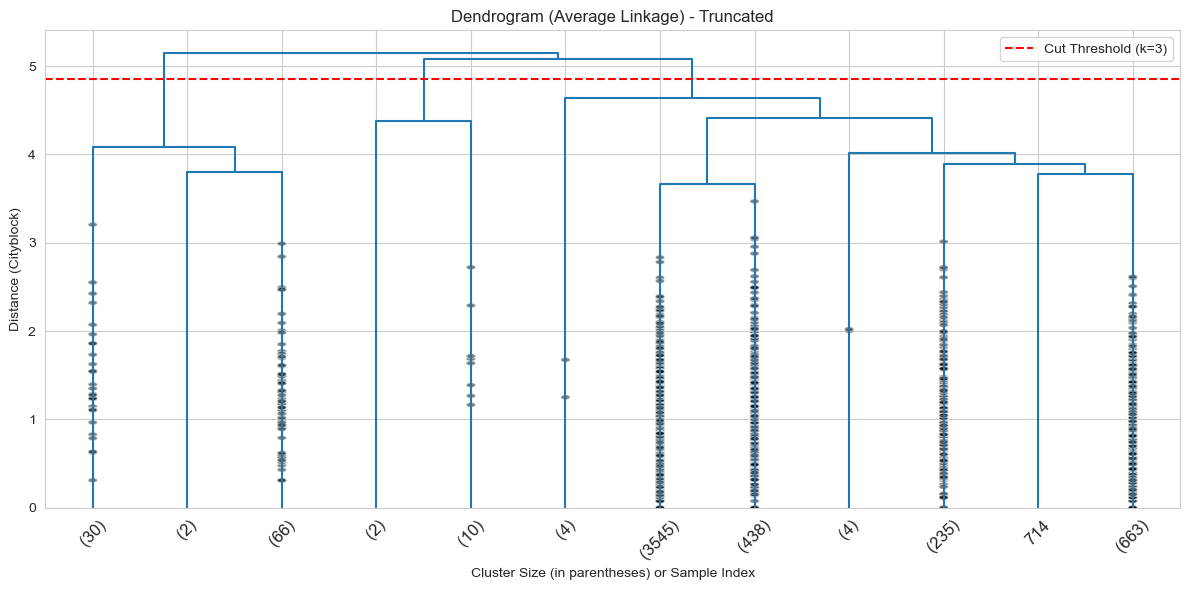

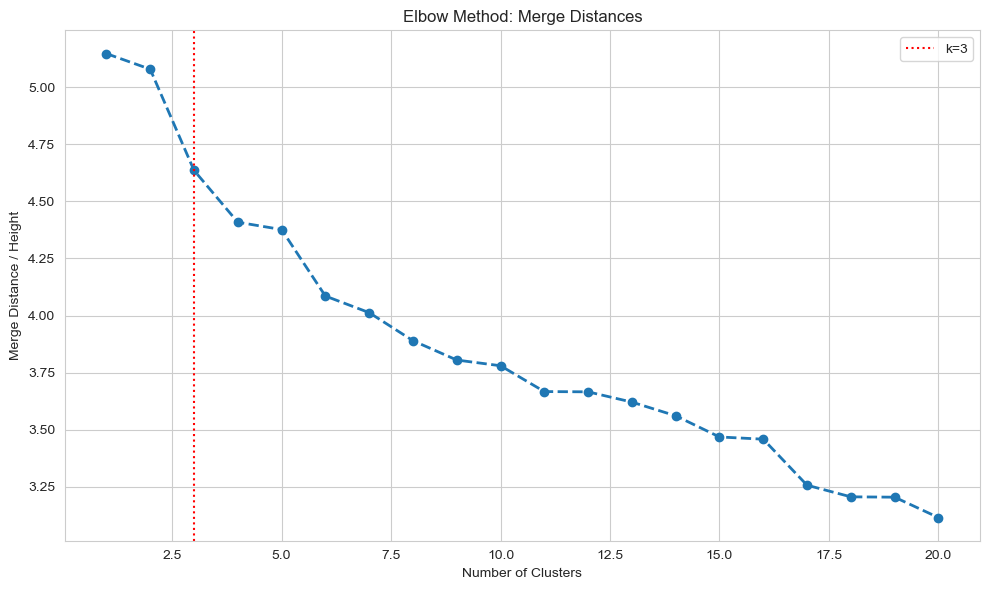

In [58]:
# -------------------------------------------------------------------------
# 3. Visualization & Thresholding (Point 3)
# -------------------------------------------------------------------------

# Plot 1: Truncated Dendrogram with Cut Line
plt.figure(figsize=(12, 6))
plt.title(f"Dendrogram ({best_params['Linkage'].capitalize()} Linkage) - Truncated")
plt.xlabel("Cluster Size (in parentheses) or Sample Index")
plt.ylabel(f"Distance ({best_params['Metric'].capitalize()})")

# Draw Dendrogram (Truncated to last p=12 branches as requested for readability)
dendrogram(
    best_linkage,
    truncate_mode='lastp',
    p=12,   # Show only the top 12 branches/clusters
    leaf_rotation=45.,
    leaf_font_size=12.,
    show_contracted=True,
    show_leaf_counts=True # Show number of samples in each collapsed branch
)

# "Cutting" the Tree (k=3)
# We find the visual cut line for 3 clusters
k_cut = 3
# The height of the merge that creates k clusters is roughly Z[-(k-1), 2]
# We want to cut slightly below that merge, but above the next merge.
cut_y = (best_linkage[-(k_cut-1), 2] + best_linkage[-k_cut, 2]) / 2 
plt.axhline(y=cut_y, c='r', linestyle='--', label=f'Cut Threshold (k={k_cut})')
plt.legend()
plt.tight_layout()
plt.show()


# Plot 2: Elbow Method for Hierarchical (Scree Plot of Distances)
plt.figure(figsize=(10, 6))
# Plot the distances of the last 20 merges (Inverted to show "Steps")
# x-axis = Number of Clusters
# y-axis = Linkage Distance
last_distances = best_linkage[:, 2][-20:][::-1]
idxs = np.arange(1, len(last_distances) + 1)
plt.plot(idxs, last_distances, marker='o', linestyle='--', linewidth=2)
plt.title("Elbow Method: Merge Distances")
plt.xlabel("Number of Clusters")
plt.ylabel("Merge Distance / Height")
plt.grid(True)

# Annotate the Elbow at k=3
plt.axvline(x=3, color='r', linestyle=':', label='k=3')
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
# -------------------------------------------------------------------------
# 4. Post-Clustering Validation (Point 5)
# -------------------------------------------------------------------------

# A. Extract Labels
k_selected = 3
cluster_labels_h = fcluster(best_linkage, k_selected, criterion='maxclust')

# B. Construct Validation DataFrame
# Combine the generated Labels with the known Target Variable (Diabetes_012)
# y_tuning_sample was preserved in the first step to ensure alignment
df_validation = pd.DataFrame({
    'Cluster_Hierarchical': cluster_labels_h,
    'Diabetes_Code': y_tuning_sample.values
})

# Map codes for readability (Assuming 0=No Diabetes, 1=Pre-Diabetes, 2=Diabetes)
status_map = {0.0: 'No Diabetes', 1.0: 'Pre-Diabetes', 2.0: 'Diabetes'}
df_validation['Diabetes_Status'] = df_validation['Diabetes_Code'].map(status_map)

# C. Cross-Tabulation Analysis
# Verify if the "High Risk" cluster actually contains the Diabetics
print(f"Validation: Cluster Composition vs Known Diabetes Status (k={k_selected})")
print("Do the clusters align with health outcomes?")

crosstab = pd.crosstab(
    df_validation['Cluster_Hierarchical'], 
    df_validation['Diabetes_Status'], 
    normalize='index' # Normalize by row to see the profile of each cluster
) * 100

# Visualize as Heatmap
display(crosstab.style.background_gradient(cmap='RdYlGn_r', axis=0).format("{:.1f}%"))

# D. Global Silhouette Check
sil_final = silhouette_score(X_tuning_sample, cluster_labels_h, metric=best_params['Metric'])
print(f"\nFinal Silhouette Score: {sil_final:.4f}")
print("(> 0.2 indicates fair structure, > 0.5 indicates strong structure)")

Validation: Cluster Composition vs Known Diabetes Status (k=3)
Do the clusters align with health outcomes?


Diabetes_Status,Diabetes,No Diabetes,Pre-Diabetes
Cluster_Hierarchical,,,
1,27.6%,68.4%,4.1%
2,25.0%,75.0%,0.0%
3,13.5%,84.8%,1.7%



Final Silhouette Score: 0.2847
(> 0.2 indicates fair structure, > 0.5 indicates strong structure)


## Step 4: Comparative Evaluation

To select the "best" model for deployment, we compare the structural quality of the clusters produced by each algorithm.

### Metrics Used
1.  **Silhouette Score:** Measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Range `[-1, 1]`. Higher is better.
2.  **Davies-Bouldin Index:** Measures the average 'similarity' between clusters, where similarity is a ratio of within-cluster distances to between-cluster distances. Lower is better (0 is perfect separation).

*Note: Due to the large dataset size (~250k records), scores are calculated on representative samples (n=10,000) to ensure computational feasibility. For K-Prototypes, the mixed-data distance is approximated using the FAMD projection.*

In [60]:
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Configuration for Evaluation
eval_sample_size = 10000
random_state = 42

comparison_results = []

print("Running Comparative Evaluation on Sample Data...")

# -------------------------------------------------------------------------
# 1. K-Means Evaluation
# -------------------------------------------------------------------------
# Data: X_kmeans (PCA Features). Labels: cluster_labels.
# Sampling:
X_kms_sample = X_kmeans.sample(n=eval_sample_size, random_state=random_state)
labels_kms_sample = kmeans_final.predict(X_kms_sample)

sil_kms = silhouette_score(X_kms_sample, labels_kms_sample)
db_kms = davies_bouldin_score(X_kms_sample, labels_kms_sample)

comparison_results.append({
    'Model': 'K-Means (PCA)',
    'Silhouette Score': sil_kms,
    'Davies-Bouldin': db_kms
})
print("K-Means metrics calculated.")

# -------------------------------------------------------------------------
# 2. K-Prototypes Evaluation
# -------------------------------------------------------------------------
# Data: X_vis_famd (FAMD Projection of Mixed Data). Labels: df_vis_sample['Cluster_Proto']
# Note: This is an approximation of the mixed-space structure.
# X_vis_famd is already limited to vis_sample_size (10,000)
# Ensure we map the labels to the same index if needed, but df_vis_sample labels align with X_vis_famd rows.
labels_proto_sample = df_vis_sample['Cluster_Proto'].values

if len(X_vis_famd) > 0:
    sil_proto = silhouette_score(X_vis_famd, labels_proto_sample)
    db_proto = davies_bouldin_score(X_vis_famd, labels_proto_sample)
    
    comparison_results.append({
        'Model': 'K-Prototypes (Mixed)',
        'Silhouette Score': sil_proto,
        'Davies-Bouldin': db_proto
    })
    print("K-Prototypes metrics calculated.")
else:
    print("Skipping K-Prototypes comparison (Data not found).")

# -------------------------------------------------------------------------
# 3. Hierarchical Evaluation
# -------------------------------------------------------------------------
# Data: X_tuning_sample (Original or PCA sample used for dendrogram). Labels: cluster_labels_h
# Note: tuning_sample_size was 5000.
sil_hier = silhouette_score(X_tuning_sample, cluster_labels_h, metric=best_params['Metric'])
db_hier = davies_bouldin_score(X_tuning_sample, cluster_labels_h)

comparison_results.append({
    'Model': 'Hierarchical',
    'Silhouette Score': sil_hier,
    'Davies-Bouldin': db_hier
})
print("Hierarchical metrics calculated.")

# -------------------------------------------------------------------------
# Summary Table
# -------------------------------------------------------------------------
comp_df = pd.DataFrame(comparison_results)
comp_df.set_index('Model', inplace=True)

print("\n--- Final Model Comparison ---")
# Formatting: Higher Silhouette is Green, Lower DB is Green (reversed cmap)
display(comp_df.style.background_gradient(cmap='Greens', subset=['Silhouette Score'])\
                     .background_gradient(cmap='Greens_r', subset=['Davies-Bouldin'])\
                     .format("{:.4f}"))

# Recommendation Logic
best_sil_model = comp_df['Silhouette Score'].idxmax()
best_db_model = comp_df['Davies-Bouldin'].idxmin()

print(f"\nConclusion:")
print(f"Based on internal validation metrics:")
print(f"- Best Silhouette (Cohesion): {best_sil_model}")
print(f"- Best Davies-Bouldin (Separation): {best_db_model}")

Running Comparative Evaluation on Sample Data...
K-Means metrics calculated.
K-Means metrics calculated.
K-Prototypes metrics calculated.
K-Prototypes metrics calculated.
Hierarchical metrics calculated.

--- Final Model Comparison ---
Hierarchical metrics calculated.

--- Final Model Comparison ---


,Silhouette Score,Davies-Bouldin
Model,,
K-Means (PCA),0.2340,1.6048
K-Prototypes (Mixed),0.2068,1.5473
Hierarchical,0.2847,1.1751



Conclusion:
Based on internal validation metrics:
- Best Silhouette (Cohesion): Hierarchical
- Best Davies-Bouldin (Separation): Hierarchical
